# Initial Data Pre-Processing and Feature Engineering
- Preparing Data for ground truth retrieval (Spotify API popularity score)
- Further EDA as needed to understand our variables
- This process will be used for entire dataset

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from langdetect import detect
from langdetect import DetectorFactory

from tqdm.notebook import tqdm

In [62]:
DetectorFactory.seed = 0

In [78]:
%%time
## read in SongCSV data
df = pd.read_csv("data/SongCSVFull.csv")
df.shape

CPU times: user 5.31 s, sys: 420 ms, total: 5.73 s
Wall time: 5.97 s


(1064090, 22)

In [79]:
df = df.sample(33000, random_state=0).reset_index(drop=True)

df.SongNumber = [int(i) if i.isnumeric() else 0 for i in df.SongNumber.values]
df = df[df.SongNumber != 0]

In [80]:
df.sample(3)

,SongNumber,SongID,AlbumID,AlbumName,ArtistID,ArtistLatitude,ArtistLocation,ArtistLongitude,ArtistName,Danceability,...,KeySignatureConfidence,Tempo,TimeSignature,TimeSignatureConfidence,Title,Year,song_hotttnesss,artist_hotttnesss,artist_mbtags,artist_mbtags_count
29268,471121,SOEHSUK12A8C14072B,220815.0,Noir Desir En Public,ARWN52K1187B9B58FF,NaN,FR,NaN,Noir Désir,0.0,...,0.292,105.302,4.0,1.000,Le Vent Nous Portera,2001.0,0.840364,0.463727,['french' 'fran\xc3\xa7ais' 'rock' 'france' 'f...,70.0
25713,755065,SOPOKQI12A6D4F69B7,22556.0,All Time Greatest Hits,AR0K52Y1187B9B69A6,34.05349,Los Angeles CA,-118.24532,The Lettermen,0.0,...,0.297,98.708,4.0,0.809,Traces/Memories (Medley) (Digitally Remastered...,0.0,0.000000,0.367507,[],2.0
4727,603405,SOHYVSS12AF72A7DD2,618593.0,The Chronicles_ Volume 2 - Chopped & Screwed,ARBXXYJ11F4C83D566,NaN,Texas,NaN,Lil Keke,0.0,...,0.155,148.477,4.0,0.478,Platinum In Da Ghetto,0.0,NaN,0.410213,[],2.0


In [81]:
df.columns

Index(['SongNumber', 'SongID', 'AlbumID', 'AlbumName', 'ArtistID',
       'ArtistLatitude', 'ArtistLocation', 'ArtistLongitude', 'ArtistName',
       'Danceability', 'Duration', 'KeySignature', 'KeySignatureConfidence',
       'Tempo', 'TimeSignature', 'TimeSignatureConfidence', 'Title', 'Year',
       'song_hotttnesss', 'artist_hotttnesss', 'artist_mbtags',
       'artist_mbtags_count'],
      dtype='object')

In [82]:
## columns used for the search, will create a searchStr column with normalized text to pass into Spotify API
search_cols = ["SongNumber", "Title", "ArtistName"]
df.sample(10)[search_cols]

,SongNumber,Title,ArtistName
3458,990129,Some Broken Hearts Never Mend,Brendan Shine
30281,323584,How Much Is That Hound Dog In The Window,Homer & Jethro
3230,982365,Wanderment,Winifred Phillips
20535,587456,Dublin,Thin Lizzy
8671,533360,100 Feet,T-Rock
23964,247066,22 Days Too Long,Adam Hood
11013,666199,I Can See - Album Version,David Meece
30556,525061,Cheek To Cheek,Steve Tyrell
21317,589804,Bassdusche 2K9,Ziggy X
18411,18311,Pray For The Morning (Tunnel Vision Album Vers...,Tunnel Rats


In [83]:
## get df search subset
df_for_search = df[search_cols]#.sample(1000)

## create SearchStr variable, standardize and lower
df_for_search["SearchStr"] = df_for_search["Title"] + " " + df_for_search["ArtistName"]
df_for_search["SearchStr"] = df_for_search["SearchStr"].apply(lambda x: str(x).lower())

<ipython-input-83-7ae850c0000e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_search["SearchStr"] = df_for_search["Title"] + " " + df_for_search["ArtistName"]
<ipython-input-83-7ae850c0000e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_search["SearchStr"] = df_for_search["SearchStr"].apply(lambda x: str(x).lower())


In [84]:
## remova nans in search string
df_for_search = df_for_search.dropna(subset=["SearchStr"])
df_for_search.sample(3)

,SongNumber,Title,ArtistName,SearchStr
24640,994339,Let's Get Started,Commodores,let's get started commodores
60,595356,Så Det På Tv,Postgirobygget,så det på tv postgirobygget
5614,494962,Mark Westlife Interviews Mankind,Mankind DC,mark westlife interviews mankind mankind dc


In [85]:
df_for_search.shape

(31054, 4)

In [86]:
## only SearchStr with letters, langdetect fails if not
# bool(re.match('^(?=.*[a-zA-Z])', " "))

In [87]:
## adding language/market feature to our dataset, using SearchStr as input
## we filtered out target markets to include only a few

target_markets = ["en", "es", "fr", "it", "nl", "pt"] # 'en' is really just 'us' though; can still add to this
market_column = []

# see progress bar below
for i in tqdm(df_for_search.SearchStr.values):

    if bool(re.match('^(?=.*[a-zA-Z])', i)):

        market = detect(i)

        if market not in target_markets:
            market_column.append("us")

        elif market in target_markets:
            if market == "en":
                market_column.append("us")
            else:
                market_column.append(market)

    else:
        print("no RegEx match...")
        market_column.append("none")
        

  0%|          | 0/31054 [00:00<?, ?it/s]

In [88]:
df_for_search["market"] = market_column

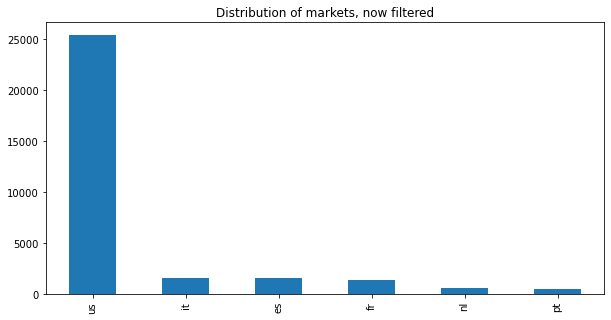

In [89]:
df_for_search.market.value_counts(sort=True).plot.bar(figsize=(10,5))
plt.title("Distribution of markets, now filtered");

In [90]:
df_for_search.head(2)
## filter out those that didn't return market
df_for_search = df_for_search[df_for_search.market != "none"]

In [91]:
df_for_search.sample(1)

,SongNumber,Title,ArtistName,SearchStr,market
32499,449733,Give Thanks to Jah,Larry Marshall,give thanks to jah larry marshall,us


In [92]:
# df_for_search.to_csv("data/search_subset.csv", index=False)